In [1]:
import math
from math import pi
import random
import glob

from tqdm.notebook import tqdm_notebook
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import dask
import dask.dataframe as dd
from dask.distributed import Client
from dask.distributed import get_client
from dask.distributed import wait

import uproot
import awkward as ak
import vector
vector.register_awkward()

from ROOT import TCanvas, TH1F, TLegend, TFile

Welcome to JupyROOT 6.26/06


### Launch a JupyterLab terminal and create a proxy
```
$ export X509_USER_PROXY=~/proxy
$ voms-proxy-init -voms cms -rfc -bits 1024
```

In [2]:
%env X509_USER_PROXY=/home/jovyan/proxy
!voms-proxy-info

env: X509_USER_PROXY=/home/jovyan/proxy
subject   : /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=egough/CN=734735/CN=Erik Gough/CN=2268239107
issuer    : /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=egough/CN=734735/CN=Erik Gough
identity  : /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=egough/CN=734735/CN=Erik Gough
type      : RFC compliant proxy
strength  : 1024 bits
path      : /home/jovyan/proxy
timeleft  : 10:44:41


### Create a DASK cluster in Kubernetes

Change the following parameters:
* name - some unique name
* claimName - claim-username

In [3]:
from dask_kubernetes.operator import KubeCluster, make_cluster_spec

# create the specifications for the cluster
# "name" must be unique
# "claimName" follows the pattern claim-<username>
name="erik-dask"
claimName="claim-goughes"
spec = make_cluster_spec(name=name,
                         n_workers=1,
                         resources={"requests": {"memory": "8Gi", "cpu": "4"}, "limits": {"memory": "8Gi", "cpu": "4"}},
                         image="geddes-registry.rcac.purdue.edu/cms/cmsaf-coffea-notebook:1.1",
                         env={"X509_USER_PROXY": "/home/jovyan/proxy"}
                        )

# add the required mount points
spec["spec"]["worker"]["spec"]["containers"][0]["volumeMounts"] = [{"name": "cvmfs", "mountPath": "/cvmfs", "mountPropagation": "HostToContainer"},
                                                                   {"name": "home", "mountPath": "/home/jovyan"}]
# update proxy-<username>
spec["spec"]["worker"]["spec"]["volumes"] = [{"name": "cvmfs", "hostPath": { "path": "/cvmfs"}},
                                             {"name": "home", "persistentVolumeClaim": {"claimName": claimName}}]


In [4]:
cluster = KubeCluster(namespace="cms", custom_cluster_spec=spec)
cluster.scale(10)
client = Client(cluster)

In [5]:
#cluster.close()

In [6]:
xrootdserver = 'root://xrootd.rcac.purdue.edu/'

files_dy =    !xrdfs root://xrootd.rcac.purdue.edu/ ls -R /store/mc/RunIISummer20UL18NanoAODv2/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v15_L1v1-v1/50000/|grep '.root$'
files_tt =    !xrdfs root://xrootd.rcac.purdue.edu/ ls -R /store/mc/RunIISummer20UL18NanoAODv2/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v15_L1v1-v1/270000/|grep '.root$'
files_data =  !xrdfs root://xrootd.rcac.purdue.edu/ ls -R /store/data/Run2018D/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9_GT36-v1/2820000/|grep '.root$'    
    
all_files_dy = [xrootdserver+ str(f) for f in files_dy]
all_files_tt = [xrootdserver+ str(f) for f in files_tt]
all_files_data = [xrootdserver+ str(f) for f in files_data]

In [7]:
cluster.scale(10)

In [8]:
def processor(file):
    import awkward as ak
    import vector
    vector.register_awkward()

    tree = uproot.open(file)["Events"]
    muons = ak.Array(
        ak.zip(
            {
                "nmu": tree["nMuon"].array(),
                "pt": tree["Muon_pt"].array(),
                "eta": tree["Muon_eta"].array(),
                "charge": tree["Muon_charge"].array(),
                "id": tree["Muon_isGlobal"].array(),
                "phi": tree["Muon_phi"].array(),
                "mass": tree["Muon_mass"].array(),
                "met": tree["MET_pt"].array()
            }
        )
    )

    muon_mask = (muons.id==1) & (muons.pt > 20) & (abs(muons.eta)<2.4)
    good_muons = muons[muon_mask]
    two_muons = good_muons[(ak.sum(muon_mask, axis=-1)==2)]
    opp_muons = two_muons.charge[:,0] != two_muons.charge[:,1]

    two_opp_good_muons = two_muons[opp_muons]

    mu_p4 = ak.Array(
        ak.zip(
            {
                "pt":two_opp_good_muons.pt,
                "eta":two_opp_good_muons.eta,
                "phi":two_opp_good_muons.phi,
                "mass":two_opp_good_muons.mass
            }
        ), with_name = "Momentum4D"
    )

    dimuon_p4 = mu_p4[:,0] + mu_p4[:,1]

    mu_cols = ["pt", "eta", "phi"]
    df_mu1 = ak.to_pandas(two_opp_good_muons[:,0][mu_cols])
    df_mu1 = df_mu1.add_prefix('mu1_')
    
    df_mu2 = ak.to_pandas(two_opp_good_muons[:,1][mu_cols])
    df_mu2 = df_mu2.add_prefix('mu2_')
    
    df_met = pd.DataFrame(two_opp_good_muons.met[:,0],columns=['MET'])

    df = pd.concat([df_mu1, df_mu2, df_met], axis=1)
    df["dimuon_mass"] = dimuon_p4.M

    return dd.from_pandas(df, npartitions=1)


In [9]:

futuresdy = client.map(processor, all_files_dy)
futurestt = client.map(processor, all_files_tt)
futuresdd = client.map(processor, all_files_data)


wait([futuresdd, futuresdy, futurestt])
  

DoneAndNotDoneFutures(done={<Future: finished, type: dask.dataframe.core.DataFrame, key: processor-b47bd5d25bd56e303d43c38ed8b4cfca>, <Future: finished, type: dask.dataframe.core.DataFrame, key: processor-9c941db84ee939acbed930a59b948c2d>, <Future: finished, type: dask.dataframe.core.DataFrame, key: processor-309cdd80863b1addc2173a35bf152a23>, <Future: finished, type: dask.dataframe.core.DataFrame, key: processor-d45264aa01217e2b296a4523ad4a6186>, <Future: finished, type: dask.dataframe.core.DataFrame, key: processor-bcb5f7b5bc4547772e986ec0f19f13db>, <Future: finished, type: dask.dataframe.core.DataFrame, key: processor-7dafbebd6dd0aa1e583784059033d318>, <Future: finished, type: dask.dataframe.core.DataFrame, key: processor-2e6198607f90389852e34e26a8a64bfa>, <Future: finished, type: dask.dataframe.core.DataFrame, key: processor-b49ad5814c48afd1d01aa84b15f76fd7>, <Future: finished, type: dask.dataframe.core.DataFrame, key: processor-233ea62e47bd6bd000ea8e9cf82bee64>, <Future: finished,

In [10]:
futures = {
    "dy": futuresdy,
    "tt": futurestt,
    "data": futuresdd
}
results = {}

for key, future in futures.items():
    results[key] = dd.concat(client.gather(future))


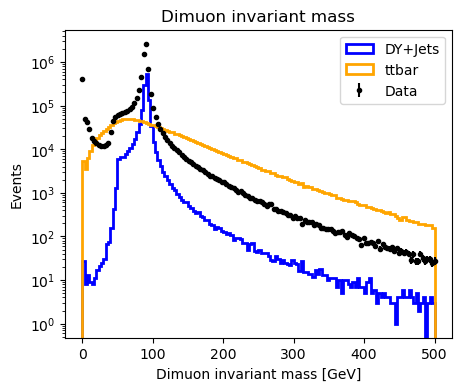

<Figure size 640x480 with 0 Axes>

In [11]:
'''Plot dimuon invariant mass'''
plt.figure(figsize=(5,4))


for key, res in results.items():
    mass = res.dimuon_mass
    
    if(key=='dy'):
        plt.hist(mass, bins=150, range=[0, 500], histtype="step",linewidth=2, color='blue', label='DY+Jets')
    elif(key == 'tt'):
        plt.hist(mass, bins=150, range=[0,500], histtype='step',linewidth=2, color='orange', label='ttbar')
    else:
        n, bins, patches = plt.hist(mass, bins=150, range=[0,500], histtype='step',linewidth=0)

        
errory = np.sqrt(n)
plt.errorbar(np.linspace(0,500,150), n,yerr= errory, fmt='o', markersize=3, color='k', label='Data')
    
plt.title('Dimuon invariant mass')
plt.xlabel('Dimuon invariant mass [GeV]')
plt.ylabel('Events')
plt.yscale('log')
plt.legend()
plt.savefig(f"dimuon_mass_parallel.pdf")
plt.show()
plt.clf()


In [12]:
load_features = ['mu1_pt', 'mu1_eta', 'mu2_pt', 'mu2_eta', 'dimuon_mass','MET']

df_sig = results['dy'][load_features]
df_bkg = results['tt'][load_features]

df_sig["label"] = 1.0
df_bkg["label"] = 0.0

dataset = dd.concat([df_sig, df_bkg], ignore_index=True)

train_data, val_data = dataset.random_split([0.7, 0.3], shuffle=True)


train_labels = train_data["label"].compute().values
val_labels = val_data["label"].compute().values

train = train_data.drop(columns=["label"]).compute()
train = train.dropna().values

val = val_data.drop(columns=["label"]).compute()
val = val.dropna().values

train_size = len(train_data)


In [13]:
'''Lets train a network and apply some selections'''

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)
# Seed
seed = 123
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes):
        super(NeuralNet, self).__init__()
        layers = []
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(nn.ReLU())
        for i in range(len(hidden_sizes)-1):

            layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            layers.append(nn.ELU())
            #layers.append(nn.Dropout(p=0.1))

        layers.append(nn.Linear(hidden_sizes[-1], num_classes))
        layers.append(nn.Sigmoid())
        self.layers = nn.ModuleList(layers)

    def get_weights(self):
        return self.weight    
    def forward(self, x):
        out = self.layers[0](x)
        for i in range(1, len(self.layers)):
            out = self.layers[i](out)

        return out


cuda


In [14]:
input_size = len(load_features)
hidden_sizes = [16, 8]
learning_rate = 0.001
num_classes = 1
num_epochs =  20
batch_size =  512


model = NeuralNet(input_size, hidden_sizes, num_classes).to(device)
model = model.float()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
decayRate = 0.6
my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

total_step = train_size

print("RUNNING... ")

for epoch in range(num_epochs):
    mean_loss = 0
    tot_wgt = 0
    val_mean_loss = 0
    val_tot_wgt = 0
    for i in range(int(train_size/batch_size)):
        # Move tensors to the configured device
        data = torch.from_numpy(train[i*batch_size: (i+1)*batch_size]).to(device)
        label = torch.from_numpy(train_labels[i*batch_size: (i+1)*batch_size].reshape((batch_size,1))).to(device)

        outputs = model(data.float())
    
        loss = criterion(outputs, label.float())
        weight_loss = loss

        # Backward and optimize
        optimizer.zero_grad()
        weight_loss.mean().backward()
        optimizer.step()
        mean_loss += weight_loss.mean().item()*batch_size

        if i%4 == 0:
            j = int(i/4)
            val_data = torch.from_numpy(val[j*batch_size: (j+1)*batch_size]).to(device)
            val_label = torch.from_numpy(val_labels[j*batch_size: (j+1)*batch_size].reshape(val_labels[j*batch_size: (j+1)*batch_size].shape[0],1)).to(device)
            val_outputs = model(val_data.float())


            val_loss = criterion(val_outputs, val_label.float())

        if (i+1) % 150 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, int(total_step/batch_size), mean_loss, val_loss))
            mean_loss=0
            tot_wgt=0
            val_mean_loss=0
            val_tot_wgt=0
    my_lr_scheduler.step()

torch.save(model.state_dict(), 'model.ckpt')

'''The model has been saved. Lets now evaluate the results'''

RUNNING... 
Epoch [1/20], Step [150/4116], Train Loss: 38662.5192, Val Loss: 0.0036
Epoch [1/20], Step [300/4116], Train Loss: 192.2934, Val Loss: 0.0010
Epoch [1/20], Step [450/4116], Train Loss: 52.5002, Val Loss: 0.0000
Epoch [1/20], Step [600/4116], Train Loss: 1.1155, Val Loss: 0.0000
Epoch [1/20], Step [750/4116], Train Loss: 0.4078, Val Loss: 0.0000
Epoch [1/20], Step [900/4116], Train Loss: 0.2193, Val Loss: 0.0000
Epoch [1/20], Step [1050/4116], Train Loss: 0.1624, Val Loss: 0.0000
Epoch [1/20], Step [1200/4116], Train Loss: 0.1108, Val Loss: 0.0000
Epoch [1/20], Step [1350/4116], Train Loss: 0.0841, Val Loss: 0.0000
Epoch [1/20], Step [1500/4116], Train Loss: 0.0621, Val Loss: 0.0000
Epoch [1/20], Step [1650/4116], Train Loss: 0.0640, Val Loss: 0.0000
Epoch [1/20], Step [1800/4116], Train Loss: 350475.3889, Val Loss: 7.2113
Epoch [1/20], Step [1950/4116], Train Loss: 22.2657, Val Loss: 8.6326
Epoch [1/20], Step [2100/4116], Train Loss: 12.2910, Val Loss: 9.4841
Epoch [1/20], 

'The model has been saved. Lets now evaluate the results'

In [15]:
'''Loading the model'''

df_sig = results['dy'][load_features]
df_bkg = results['tt'][load_features]
df_data = results['data'][load_features]


def inference(df):
    device = torch.device('cpu')
    model = NeuralNet(6, [16, 8], 1).to(device)
    model.load_state_dict(torch.load("model.ckpt", map_location=torch.device('cpu')))
    model.eval()
    df = torch.from_numpy(df.compute().values).to(device).float()
    scores = model(df) 
    scores = scores.cpu().detach().numpy()
    return scores.ravel()  


scattered_data = client.scatter([df_sig, df_bkg, df_data])
futures = client.map(inference, scattered_data)
dnn_sig, dnn_bkg, dnn_data = client.gather(futures)


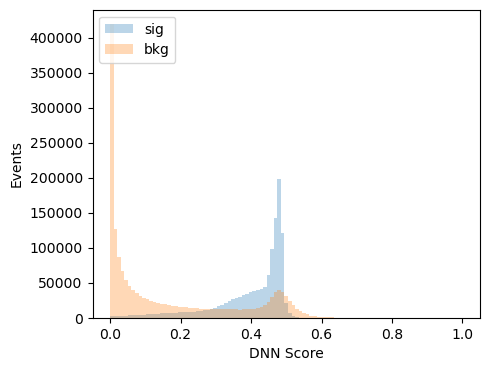

In [16]:

bins = np.linspace(0, 1, 100)
plt.figure(figsize=(5,4))


plt.hist(dnn_sig, bins, alpha=0.3, label='sig')
plt.hist(dnn_bkg, bins, alpha=0.3, label='bkg')
plt.xlabel('DNN Score')
plt.ylabel('Events')
plt.legend(loc='upper left')


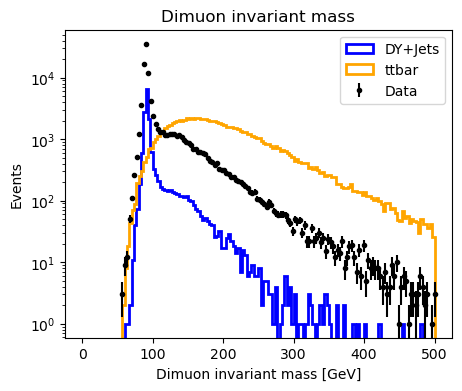

<Figure size 640x480 with 0 Axes>

In [17]:
DNN_CUT = 0.5

dy_mass_dnn = df_sig["dimuon_mass"].compute()[dnn_sig>DNN_CUT]
tt_mass_dnn = df_bkg["dimuon_mass"].compute()[dnn_bkg>DNN_CUT]
data_mass_dnn = df_data["dimuon_mass"].compute()[dnn_data>DNN_CUT]


'''Plot dimuon invariant mass'''
plt.figure(figsize=(5,4))

plt.hist(dy_mass_dnn, bins=150, range=[0,500], histtype='step',linewidth=2, color='blue', label='DY+Jets')
plt.hist(tt_mass_dnn, bins=150, range=[0,500], histtype='step',linewidth=2, color='orange', label='ttbar')
n, bins, patches = plt.hist(data_mass_dnn, bins=150, range=[0,500], histtype='step',linewidth=0)

errory = np.sqrt(n)
plt.errorbar(np.linspace(0,500,150), n,yerr= errory, fmt='o', markersize=3, color='k', label='Data')

plt.title('Dimuon invariant mass')
plt.xlabel('Dimuon invariant mass [GeV]')
plt.ylabel('Events')
#plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.savefig(f"dimuon_mass_dnncut_parallel.pdf")
plt.show()
plt.clf()

In [18]:
cluster.close()